In [1]:
#enable access to dataset through Google Drive
from google.colab import drive
drive.mount('/content/drive')

#import necessary libraries
import numpy as np
import h5py
import matplotlib.pyplot as plt
import scipy
from PIL import Image
from scipy import ndimage
%matplotlib inline


Mounted at /content/drive


<KeysViewHDF5 ['list_classes', 'train_set_x', 'train_set_y']>
(209, 64, 64, 3)
(209,)
(2,)
[b'non-cat' b'cat']
Cost after iteration 0 is: 0.6931471805599453
Cost after iteration 500 is: 0.2784984357971258
Cost after iteration 1000 is: 0.189109561530962
Cost after iteration 1500 is: 0.1446766125630104
Cost after iteration 2000 is: 0.11668662340424087
Cost after iteration 2500 is: 0.09748350008195465
Cost after iteration 3000 is: 0.08353175113117936
Cost after iteration 3500 is: 0.07296043263358017
Cost after iteration 4000 is: 0.06468783540438965
Cost after iteration 4500 is: 0.05804649323740332
Cost after iteration 5000 is: 0.05260302692698633
Cost after iteration 5500 is: 0.04806419858871157
Cost after iteration 6000 is: 0.04422470335803405
Cost after iteration 6500 is: 0.040936614749454966
Cost after iteration 7000 is: 0.03809071118420869
Cost after iteration 7500 is: 0.03560463429690859
Cost after iteration 8000 is: 0.033415136123296815
Cost after iteration 8500 is: 0.03147286008082

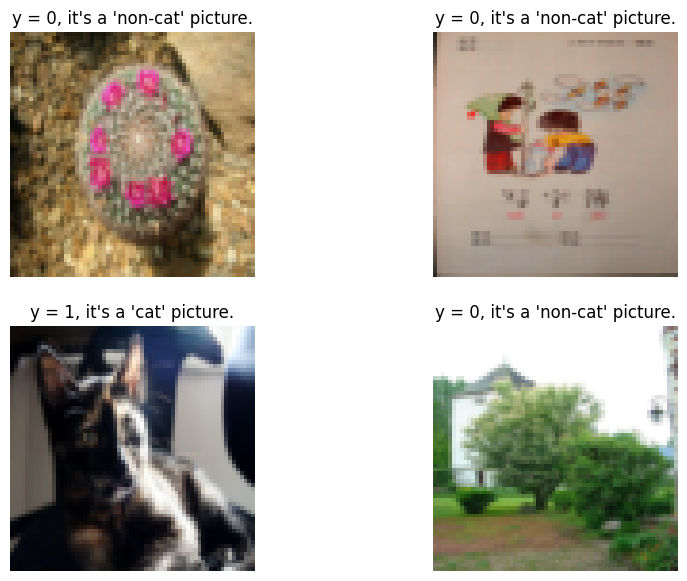

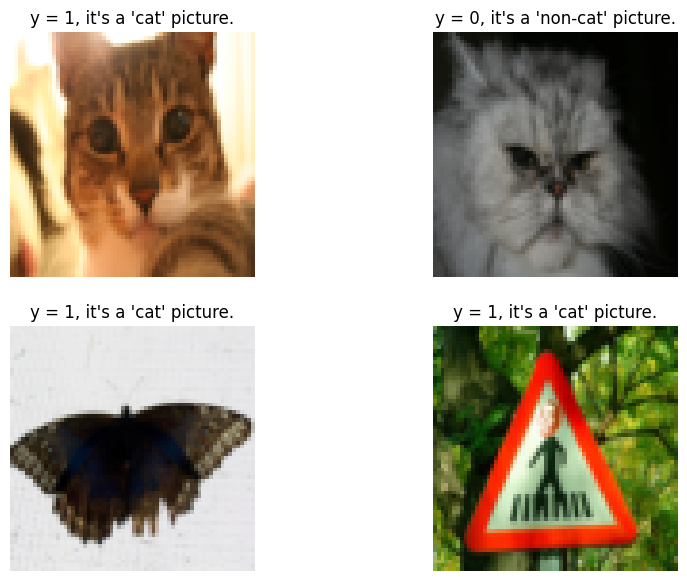

In [ ]:

#load the training and testing datasets from my Google Drive
train_data = h5py.File('drive/My Drive/ams595/python2/train_catvnoncat.h5', "r")
test_data = h5py.File('drive/My Drive/ams595/python2/test_catvnoncat.h5', "r")

#print the dataset keys
#   each dataset is a dictionary, and the keys let us extract inputs (X) and outputs (Y)
print(train_data.keys())

#extract the inputs and outputs for the training and test datasets
#   in addition, get a list of the classes: cat and non-cat
train_set_x = train_data['train_set_x']
train_set_y = train_data['train_set_y']
test_set_x = test_data['test_set_x']
test_set_y = test_data['test_set_y']
list_classes = train_data['list_classes']
# for c in list_classes:
#     print(c)

#put training and testing subdatasets into respective arrays of inputs (X) and outputs (Y)
train_X = np.array(train_set_x[:])
train_Y = np.array(train_set_y[:])
test_X = np.array(test_set_x[:])
test_Y = np.array(test_set_y[:])
classes = np.array(list_classes[:])

#display the shapes of the classes, in addition to the classes themselves
print(train_X.shape)
print(train_Y.shape)
print(classes.shape)
print(classes)

# Reshape the labels
train_Y = train_Y.reshape((1, train_Y.shape[0]))
test_Y = test_Y.reshape((1, test_Y.shape[0]))

# Indices of images to display
train_indices = [52, 53, 54, 55]
test_indices = [11, 12, 13, 14]

# Plot images
def plot_images(data, indices, title):
    fig = plt.figure(figsize=(10, 7))
    rows, columns = 2, 2

    for i, idx in enumerate(indices):
        fig.add_subplot(rows, columns, i + 1)
        plt.imshow(data[idx])
        plt.axis('off')
        plt.title("y = " + str(train_Y[0, idx]) + ", it's a '" + classes[np.squeeze(train_Y[:, idx])].decode("utf-8") + "' picture.")

#plot a sample of training set images
#   the plotted images stem from the train_X dataset
#   the specific images are based on the values in the train_indices list
plot_images(train_X, train_indices, "Training Set Images")

#plot a sample of test set images
#   the plotted images stem from the test_X dataset
#   the specific images are based on the values in the test_indices list
plot_images(test_X, test_indices, "Test Set Images")

#flatten and normlalize the images
train_X_flat = (train_X.reshape(train_X.shape[0], -1) / 255).T
test_X_flat = (test_X.reshape(test_X.shape[0], -1) / 255).T

#define our sigmoid functin to be the logistic function
#   the logistic function is well-suited for binary classification
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

#define forward and backpropogation for training our model
def propagate(w, b, X, Y):
    m = X.shape[1]
    A = sigmoid(np.dot(w.T, X) + b)
    cost = np.sum(((-np.log(A)) * Y + (-np.log(1 - A)) * (1 - Y)))/m
    dw = (np.dot(X, (A - Y).T)) / m
    db = (np.sum(A - Y)) / m
    cost = np.squeeze(cost)
    return dw, db, cost

#initialize model parameters and training hyperparameters
X = train_X_flat
Y = train_Y
dim = train_X_flat.shape[0]
w = np.zeros((dim, 1))
b = 0
num_iterations = 10000
learning_rate = 0.006
record_cost = 500
costs = []

#iteratively train the model via gradient descent
for i in range(num_iterations):
    dw, db, cost = propagate(w, b, X, Y)
    w = w - (learning_rate * dw)
    b = b - (learning_rate * db)
    if i % record_cost == 0:
        costs.append(cost)
        print(f"Cost after iteration {i} is: {cost}")

#save the learned parameters
scipy.io.savemat("weights.mat", {"weights": w})
scipy.io.savemat("biases.mat", {"biases": b})

#load the learned parameters for testing
w = scipy.io.loadmat('weights.mat')["weights"]
b = scipy.io.loadmat('biases.mat')["biases"]

# Predictions and Accuracy
A = sigmoid(np.dot(w.T, test_X_flat) + b)
Y_predict_test = (A >= 0.5) * 1.0
Y_predict_train = sigmoid(np.dot(w.T, X) + b)

print(f"Train accuracy: {(100 - np.mean(np.abs(Y_predict_train - train_Y)) * 100):.2f}")
print(f"Test accuracy: {(100 - np.mean(np.abs(Y_predict_test - test_Y)) * 100):.2f}")


Indices of wrong test set predictions: [6, 10, 11, 13, 18, 19, 24, 28, 29, 30, 34, 41, 44, 45, 46]


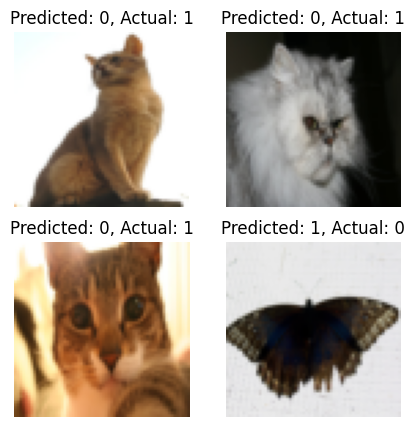

In [ ]:
incorrect_indices = []  # Create an array to store indices of incorrect predictions

num_of_test_X_images = test_X_flat.shape[1]
for i in range(num_of_test_X_images):
    A = sigmoid(np.dot(w.T, test_X_flat[:, i]) + b)
    Y_predict = (A >= 0.5) * 1.0

    #if the predicted value (based on test_X) is not equivalent to the actual value (based on test_Y)
    #   then append that i index to the incorrect_indices list
    if Y_predict != test_Y[0, i]:
        incorrect_indices.append(i)  # Append the index to the list of incorrect predictions

# Print the indices of incorrect predictions
print(f'Indices of wrong test set predictions: {incorrect_indices}')

# Display 4 of these failed cases for visual examination
fig = plt.figure(figsize=(5, 5))

for i in range(4):
    fig.add_subplot(2, 2, i+1)
    img_index = incorrect_indices[i]
    plt.imshow(test_X[img_index])
    plt.axis('off')
    plt.title("Predicted: " + str(int(Y_predict_test[0, img_index])) + ", Actual: " + str(test_Y[0, img_index]))

plt.show()
